This notebook we add the midpoint baseline; and test the new version of generate random and centroid (that is consistant with the area test).

In [1]:
import graph_create, voronoi_local, jaccard_similarity, figure_plot

import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from scipy.spatial import Voronoi

-----

## Read in the graph

We read in the vein network and the dots as a combined graph object, with the single dots in non overlapping faces highlighted in orange.

In [2]:
sample = 'Pilea2'
G = graph_create.graph_creation(sample)

Creating graph from vein and dot tracing images.

- Step1: reading files...

- Step2: create dot graph...

- Step3: read vein graph...

- Step4: merge graphs...

- Step5: find testable faces...

Graph creation completed.



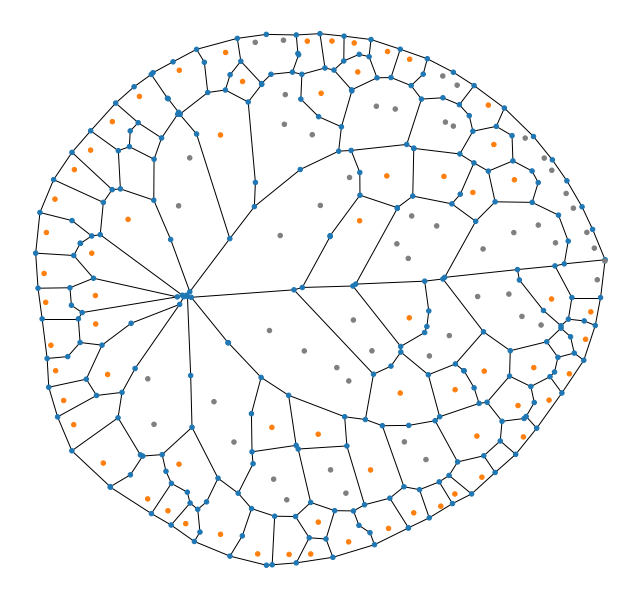

In [3]:
figure_plot.quick_plot(G)

-----

## Perform local tests

For the "one face - one dot" dots, we locally test the voronoi properties between it and other eligible dots in the adjacent faces. We ask whether the line segment connecting two dots is perpendicualar to the shared edges of the face, and whether their distance to the edge is the same.

In [4]:
# local tests:
adj_faces_mat, shared_edges_mat = voronoi_local.shared_edges(G, threshold = 50)
rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat,G.graph['dots_passed'], G, dot_bool = True)
rst[2]

,mean angle error,std angle error,mean distance error,std distance error
0,9.772088,9.803922,0.266168,0.225829


We use the centroid dots and random dots in the face as baselines for the local test.

In [5]:
# baseline local tests:
cent_in_faces, mid_in_faces, rand_in_faces = voronoi_local.random_n_centroid(G)

In [6]:
centroid_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, cent_in_faces)
midpoint_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat ,mid_in_faces)
random_rst = voronoi_local.local_test(adj_faces_mat, shared_edges_mat, rand_in_faces)

-----

## Visualize local test

we color the dual edges (by connecting dots) to represent test performance.

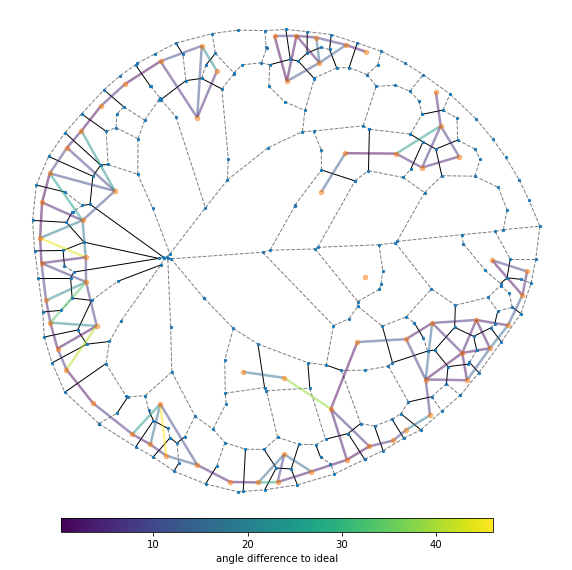

In [7]:
G_dual = graph_create.make_dual(G, cent_in_faces, mid_in_faces, rand_in_faces, rst[0])
figure_plot.plot_dual(G, G_dual, attr = "angle")

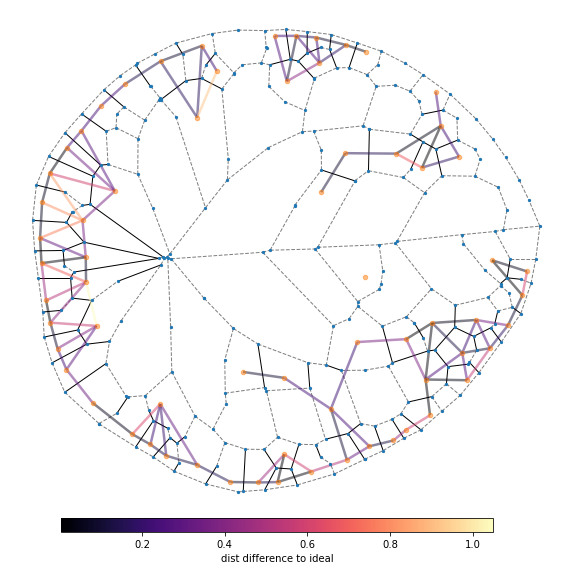

In [8]:
figure_plot.plot_dual(G, G_dual, attr = "dist")

-------
## Visualize baseline

We plot location of the baseline nodes (centroids in purple, random in red) in comparsion to that of the dots.

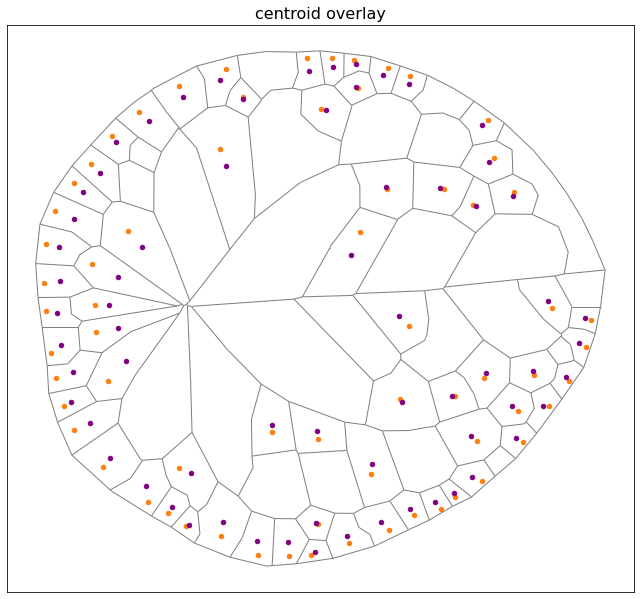

In [9]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'centroid')

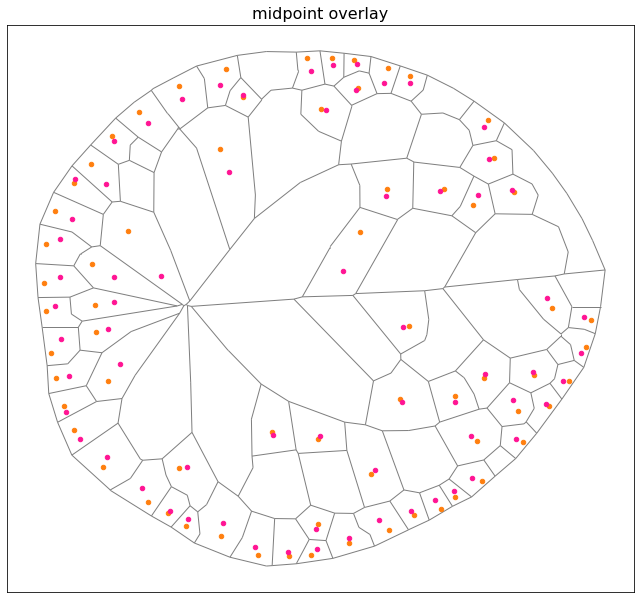

In [10]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'midpoint')

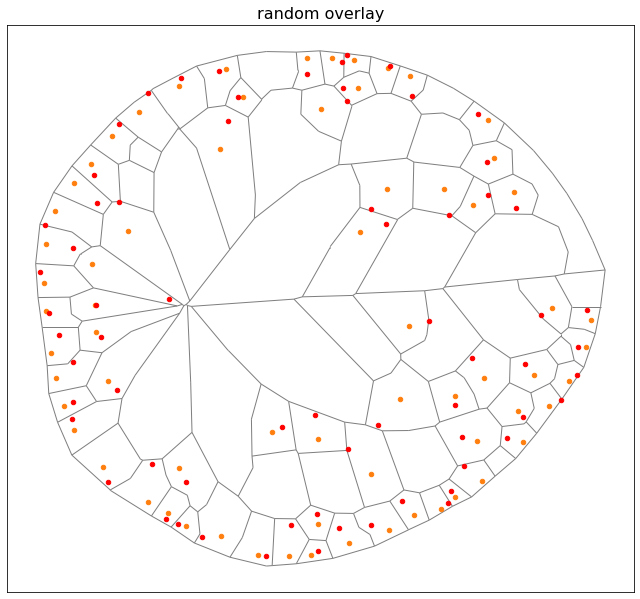

In [11]:
figure_plot.plot_baseline(G, G_dual, pt_type = 'random')

-------
## Statistically compare dot-pair performance in all passed faces

In [12]:
# combine local test results:
rst_df = rst[1]
rst_df['type'] = 'dot'
cent_df = centroid_rst[1]
cent_df['type'] = 'centroid'
mid_df = midpoint_rst[1]
mid_df['type'] = 'midpoint'
rand_df = random_rst[1]
rand_df['type'] = 'random'

df = pd.concat([rst_df, cent_df, mid_df, rand_df])

In [13]:
_, p_angle = mannwhitneyu(random_rst[1]['angle_diff'], rst[1]['angle_diff'])
_, p_dist = mannwhitneyu(random_rst[1]['dist_diff'], rst[1]['dist_diff'])

print('Mann Whitney U test result for angle error (random v.s. dot):', p_angle)
print('Mann Whitney U test result for percent distance error:', p_dist)


Mann Whitney U test result for angle error (random v.s. dot): 7.286039479140343e-07
Mann Whitney U test result for percent distance error: 7.490690565754012e-16


In [14]:
_, p_angle = mannwhitneyu(midpoint_rst[1]['angle_diff'], rst[1]['angle_diff'])
_, p_dist = mannwhitneyu(midpoint_rst[1]['dist_diff'], rst[1]['dist_diff'])

print('Mann Whitney U test result for angle error (random v.s. dot):', p_angle)
print('Mann Whitney U test result for percent distance error:', p_dist)

Mann Whitney U test result for angle error (random v.s. dot): 0.011615826847416721
Mann Whitney U test result for percent distance error: 3.651904694378483e-06


In [15]:
_, p_angle = mannwhitneyu(centroid_rst[1]['angle_diff'], rst[1]['angle_diff'])
_, p_dist = mannwhitneyu(centroid_rst[1]['dist_diff'], rst[1]['dist_diff'])

print('Mann Whitney U test result for angle error (random v.s. dot):', p_angle)
print('Mann Whitney U test result for percent distance error:', p_dist)

Mann Whitney U test result for angle error (random v.s. dot): 0.42426516572545553
Mann Whitney U test result for percent distance error: 0.005783451668293223


------
## Plot distributions of errors

We plot the local test result distributions.

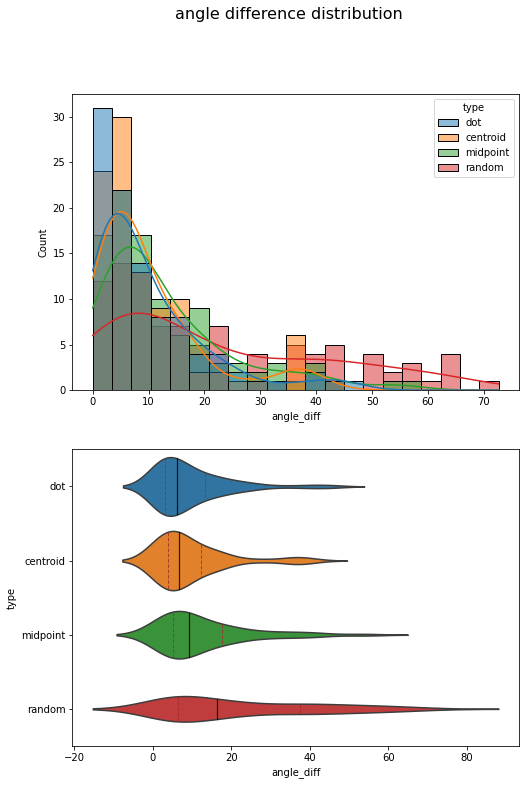

In [16]:
figure_plot.plot_dist(df, test = 'angle')

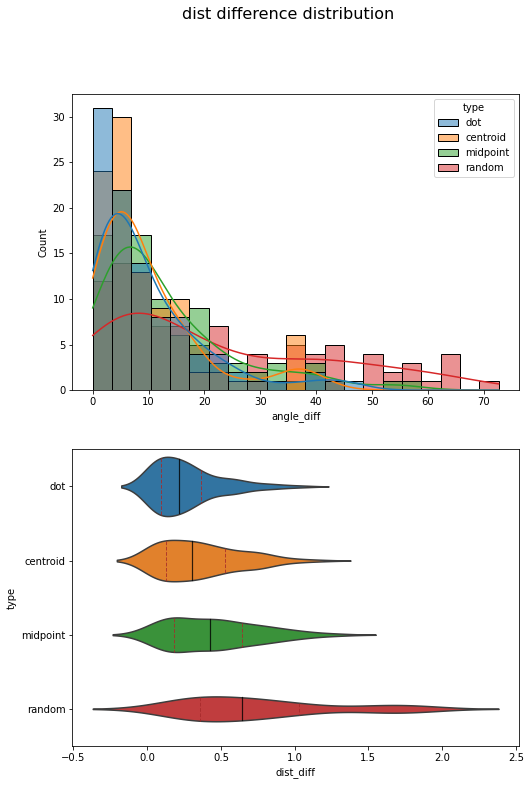

In [17]:
figure_plot.plot_dist(df, test = 'dist')

-------
## Visualize Voronoi Overlay

Plot voronoi diagram generated by the dots as seeds. Later we'll perform area overlap test for faces.

In [18]:
seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
vor = Voronoi(seeds)

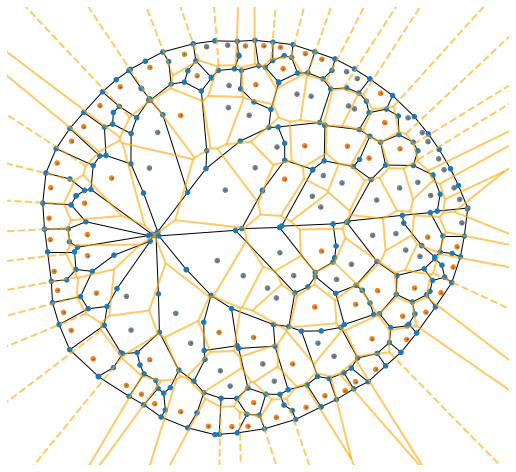

In [19]:
figure_plot.plot_voronoi(G, vor)

In [20]:
baseline_summary = pd.DataFrame(np.array([rst[2].iloc[0].tolist(), centroid_rst[2].iloc[0].tolist(), midpoint_rst[2].iloc[0].tolist(), random_rst[2].iloc[0].tolist()]), 
                                    columns = ['angle_mean', 'angle_std', 'dist_mean', 'dist_std'],
                                    index = ['dot', 'centroid', 'midpoint','random'])

In [21]:
baseline_summary

,angle_mean,angle_std,dist_mean,dist_std
dot,9.772088,9.803922,0.266168,0.225829
centroid,9.895719,9.738768,0.358859,0.268549
midpoint,12.877475,11.719683,0.450328,0.306075
random,22.390708,19.433833,0.756300,0.515351


-------
### Visualize where dots perform less well compared to centroid:

In [22]:
dual_edge_list = []
M = len(shared_edges_mat)
for i in range(M):
    node1 = G.graph['dots_passed'][i]
    for j in range(i+1, M):
        # if they are adjacent:
        if adj_faces_mat[i][j]:
            node2 = G.graph['dots_passed'][j]
            dual_edge_list.append((node1, node2))

G_dual_bad_angles = graph_create.create_dual_subgraph(G_dual, rst_df, cent_df, dual_edge_list,  attr = 'angle')
G_dual_bad_dists = graph_create.create_dual_subgraph(G_dual, rst_df, cent_df, dual_edge_list, attr = 'dist')


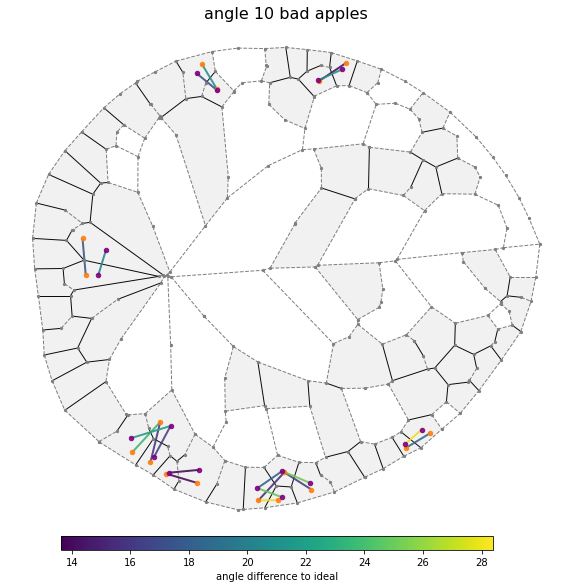

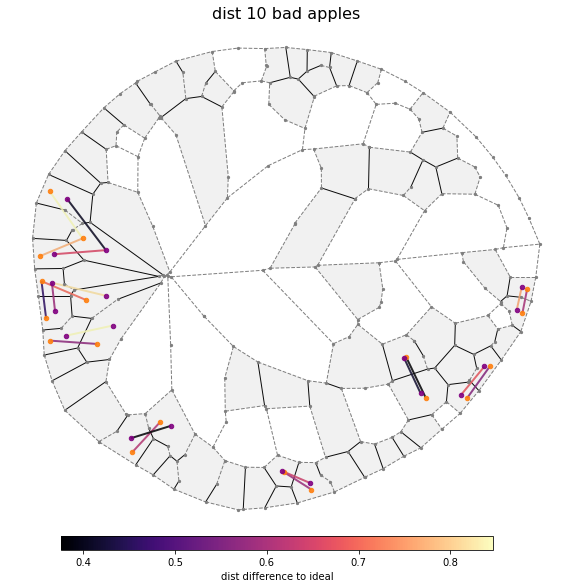

In [23]:
figure_plot.plot_subdual(G, G_dual_bad_angles, attr = "angle")
figure_plot.plot_subdual(G, G_dual_bad_dists, attr = "dist")

-------------

### Perform area test

In [24]:
seeds = [n for n in G.nodes if G.nodes[n]['type'] != 'vein']
vor = Voronoi(seeds)
bounded_regions = jaccard_similarity.bounded_polygons(G, vor)
J_list = jaccard_similarity.overlap_test(G, seeds, bounded_regions)

In [25]:
centroid_seeds, midpoint_seeds, random_seeds = jaccard_similarity.hybrid_seeds(G)

centroid_vor = Voronoi(centroid_seeds)
midpoint_vor =  Voronoi(midpoint_seeds)
random_vor = Voronoi(random_seeds)

centroid_bounded_regions = jaccard_similarity.bounded_polygons(G, centroid_vor)
midpoint_bounded_regions = jaccard_similarity.bounded_polygons(G, midpoint_vor)
random_bounded_regions = jaccard_similarity.bounded_polygons(G, random_vor)

centroid_J_list = jaccard_similarity.overlap_test(G, seeds, centroid_bounded_regions)
midpoint_J_list = jaccard_similarity.overlap_test(G, seeds, midpoint_bounded_regions)
random_J_list = jaccard_similarity.overlap_test(G, seeds, random_bounded_regions)

J_df = pd.DataFrame(np.array([J_list, centroid_J_list, midpoint_J_list, random_J_list ]).T, columns = ['dots', 'centroid', 'midpoint', 'random'])

J_df.head()


,dots,centroid,midpoint,random
0,0.696782,0.829755,0.630504,0.410695
1,0.752614,0.825276,0.717323,0.226151
2,0.800663,0.740018,0.528007,0.333919
3,0.430057,0.723236,0.449398,0.391704
4,0.680188,0.778749,0.725140,0.359119


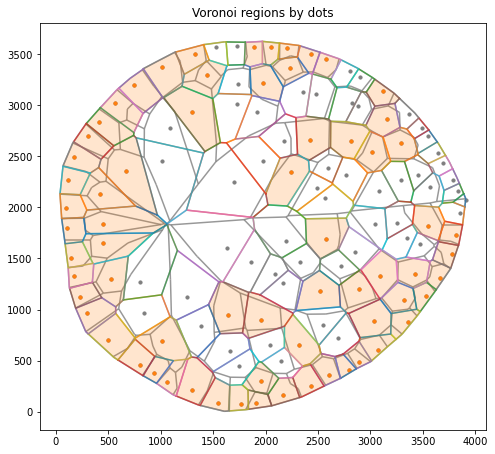

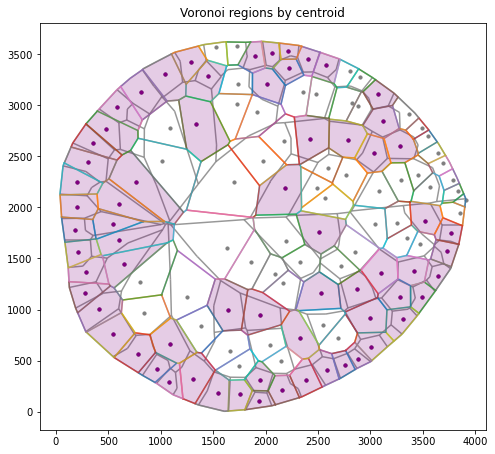

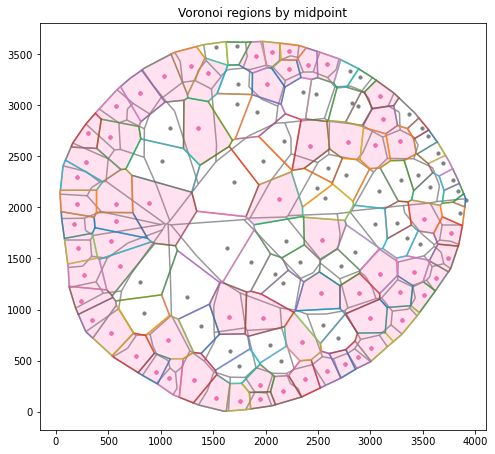

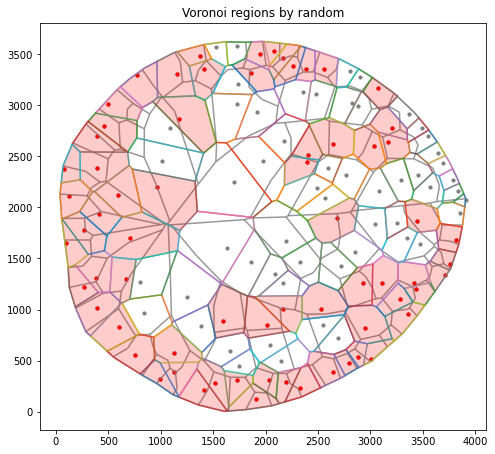

In [26]:
single_dot = [G.nodes[seed]['type'] == 'single_dot' for seed in seeds]

figure_plot.plot_vor_regions(G, seeds, single_dot, bounded_regions, dot_type = 'dots')
figure_plot.plot_vor_regions(G, centroid_seeds, single_dot, centroid_bounded_regions, dot_type = 'centroid')
figure_plot.plot_vor_regions(G, midpoint_seeds, single_dot, midpoint_bounded_regions, dot_type = 'midpoint')
figure_plot.plot_vor_regions(G, random_seeds, single_dot, random_bounded_regions, dot_type = 'random')